In [29]:
import pandas as pd
from datetime import datetime, timedelta
import os
import asyncio
from binance.client import AsyncClient, HistoricalKlinesType


In [2]:
client = await AsyncClient.create()

<h1>DOWNLOADER F()</h1>

In [3]:
async def get_batch_historical_candles(symbols, days, interval = "1m", klines_type=HistoricalKlinesType.SPOT, limit_per_second = 2):
  new_dir = "Binance_Historical_%s_%s_%i_days_%s" % (interval, klines_type.name, days, str(datetime.utcnow().replace(microsecond=0).isoformat()))
  os.mkdir(new_dir)
  now = datetime.utcnow()
  start = str(now - timedelta(days = days))
  
  chunks = []
  for idx, _ in enumerate(symbols):
    if idx % limit_per_second == 0:
      symbols_chunk = symbols[idx:idx+limit_per_second]
      futures_chunk = []
      
      for symbol in symbols_chunk:
        futures_chunk.append(client.get_historical_klines(symbol = symbol, interval = interval,
                                      start_str = start, end_str = None, limit = 1000, klines_type=klines_type))
        
      chunks.append(futures_chunk)
      
  for index, chunk in enumerate(chunks):
    print("Fetching data for ↓ %s %s" % (klines_type.name, interval), "%i / %i" % (index, len(chunks)))
    results = await asyncio.gather(*chunk)
    
    for i, bars in enumerate(results):
      print(symbols[index*limit_per_second+i])
      try:
        df = bars_to_df(bars)
        df.to_csv("%s/%s_%s_%s.csv" % (new_dir, symbols[index*limit_per_second+i], klines_type.name, interval))
      except:
        print("raw: ", bars)
        print("Couldn't construct DataFrame from raw data for %s" % symbols[index*limit_per_second+i])
    
def bars_to_df(bars):
  df = pd.DataFrame(bars)
  df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
  df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                "Close Time", "Quote Asset Volume", "Number of Trades",
                "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
  df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
  df.set_index("Date", inplace = True)
  for column in df.columns:
      df[column] = pd.to_numeric(df[column], errors = "coerce")
      
  return df
      

In [4]:
futures_info = await client.futures_exchange_info()
spot_info = await client.get_exchange_info()

In [5]:
symbols_futures = list(map(lambda x: x['symbol'], futures_info['symbols']))
symbols_spot = list(map(lambda x: x['symbol'], spot_info['symbols']))


In [6]:
await get_batch_historical_candles(symbols=symbols_futures, days=2, interval="1m", limit_per_second=6, klines_type=HistoricalKlinesType.FUTURES)
await get_batch_historical_candles(symbols=symbols_spot, days=2, interval="1m", limit_per_second=6, klines_type=HistoricalKlinesType.SPOT)


Fetching data for ↓ FUTURES 1m 0 / 28
BTCUSDT
ETHUSDT
BCHUSDT
XRPUSDT
EOSUSDT
LTCUSDT
Fetching data for ↓ FUTURES 1m 1 / 28
TRXUSDT
ETCUSDT
LINKUSDT
XLMUSDT
ADAUSDT
XMRUSDT
Fetching data for ↓ FUTURES 1m 2 / 28
DASHUSDT
ZECUSDT
XTZUSDT
BNBUSDT
ATOMUSDT
ONTUSDT
Fetching data for ↓ FUTURES 1m 3 / 28
IOTAUSDT
BATUSDT
VETUSDT
NEOUSDT
QTUMUSDT
IOSTUSDT
Fetching data for ↓ FUTURES 1m 4 / 28
THETAUSDT
ALGOUSDT
ZILUSDT
KNCUSDT
ZRXUSDT
COMPUSDT
Fetching data for ↓ FUTURES 1m 5 / 28
OMGUSDT
DOGEUSDT
SXPUSDT
KAVAUSDT
BANDUSDT
RLCUSDT
Fetching data for ↓ FUTURES 1m 6 / 28
WAVESUSDT
MKRUSDT
SNXUSDT
DOTUSDT
DEFIUSDT
YFIUSDT
Fetching data for ↓ FUTURES 1m 7 / 28
BALUSDT
CRVUSDT
TRBUSDT
RUNEUSDT
SUSHIUSDT
SRMUSDT
Fetching data for ↓ FUTURES 1m 8 / 28
EGLDUSDT
SOLUSDT
ICXUSDT
STORJUSDT
BLZUSDT
UNIUSDT
Fetching data for ↓ FUTURES 1m 9 / 28
AVAXUSDT
FTMUSDT
HNTUSDT
ENJUSDT
FLMUSDT
TOMOUSDT
Fetching data for ↓ FUTURES 1m 10 / 28
RENUSDT
KSMUSDT
NEARUSDT
AAVEUSDT
FILUSDT
RSRUSDT
Fetching data for ↓ FUTURES

- downloaded data is placed in new directory in the root, so it can be easily cleaned
- target data sets that we want to preserve should be manually moved to `./raw_data` dir

<h1>Raw Data Processing </h1>

<h3>Merging time series</h3>
<table>
<tr>
<th>[BTCUSDT]</th>
<th>[ETHUSDT]</th>
</tr>
<tr>
<td>[Close]</td>
<td>[Close]</td>
</tr>
<table>

In [2]:
import pandas as pd
import os

In [3]:
directories = ["Binance_Historical_1m_FUTURES_2_days_2022-06-07T21:34:10", "Binance_Historical_1m_SPOT_2_days_2022-06-07T21:35:14"]

In [4]:
df_closings = pd.DataFrame()
with os.scandir('raw_data/%s' % directories[0]) as entries:
    for idx, entry in enumerate(entries):
        instrument = "_".join(entry.name.split("_")[0:2])
        df = pd.read_csv('raw_data/%s/%s' % (directories[0], entry.name), index_col="Date")
        df = df[["Close"]].copy()
        df.columns = [instrument]
        df_closings = pd.concat([df_closings, df], axis=1)
        
with os.scandir('raw_data/%s' % directories[1]) as entries:
    for idx, entry in enumerate(entries):
        instrument = "_".join(entry.name.split("_")[0:2])
        df = pd.read_csv('raw_data/%s/%s' % (directories[1], entry.name), index_col="Date")
        df = df[["Close"]].copy()
        df.columns = [instrument]
        df_closings = pd.concat([df_closings, df], axis=1)
        
df_closings.index = pd.to_datetime(df_closings.index)       

In [5]:
df_closings.fillna(method="ffill", inplace=True)
df_closings.fillna(value=0, inplace=True)

In [6]:
df_closings.iloc[:, 10:20]

,OPUSDT_FUTURES,RSRUSDT_FUTURES,GRTUSDT_FUTURES,BTCBUSD_FUTURES,LITUSDT_FUTURES,ANKRUSDT_FUTURES,ATOMUSDT_FUTURES,1000XECUSDT_FUTURES,FLMUSDT_FUTURES,UNIUSDT_FUTURES
Date,,,,,,,,,,
2022-06-05 21:35:00,1.2034,0.006922,0.15808,29836.0,0.613,0.03916,9.267,0.04824,0.0943,5.136
2022-06-05 21:36:00,1.1998,0.006924,0.15797,29827.0,0.613,0.03913,9.260,0.04822,0.0943,5.138
2022-06-05 21:37:00,1.1993,0.006916,0.15804,29846.6,0.613,0.03914,9.259,0.04823,0.0944,5.142
2022-06-05 21:38:00,1.2031,0.006906,0.15809,29843.7,0.613,0.03908,9.267,0.04825,0.0943,5.138
2022-06-05 21:39:00,1.2004,0.006918,0.15828,29846.0,0.613,0.03910,9.266,0.04824,0.0944,5.140
...,...,...,...,...,...,...,...,...,...,...
2022-06-07 21:41:00,1.1827,0.010323,0.15570,31267.0,0.844,0.04019,9.035,0.05680,0.0978,5.350
2022-06-07 21:42:00,1.1827,0.010323,0.15570,31267.0,0.844,0.04019,9.035,0.05680,0.0978,5.350
2022-06-07 21:43:00,1.1827,0.010323,0.15570,31267.0,0.844,0.04019,9.035,0.05680,0.0978,5.350


In [7]:
import numpy as np
import statsmodels.tsa.stattools as ts

In [31]:
import warnings
warnings.filterwarnings('ignore')

def cointegrated_pairs(data):
    n =  (len(data.columns) -1)
    stocks = data.iloc[:,1:].columns.values #pulls all stock names 
    data = data.to_numpy()
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = np.empty((n*n,3),dtype=object)
    m = 0
    # loop through all possilbe combintions of stocks ie 3!=6
    for i in range(0,n):
        for j in range(0,n):
            S1 = data[:,i+1]
            S2 = data[:,j+1]
            result = ts.coint(S1,S2)
            pvalue_matrix[i,j] = result[1]
            #storing all paris in matrix form
            if (result[1] < 0.05) & (i!=j):
                pairs[m,0] = stocks[i]
                pairs[m,1] = stocks[j] 
                pairs[m,2] = result[1]
                m = m + 1
    try:
        a_file = open("pairs_temp_%s.txt" % str(datetime.utcnow().replace(microsecond=0).isoformat()), "w")
        for row in pairs:
            if row[0] is not None:
                a_file.write("%s/%s: %s\n" % (row[0], row[1], row[2]))
        a_file.close()
    except:
       print("Couldn't save pairs to txt file") 
       
    return pvalue_matrix,  pairs

In [32]:
pvalue_matrix,  pairs = cointegrated_pairs(df_closings.iloc[:, 10:20])

In [ ]:
# pvalue_matrix
pairs

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

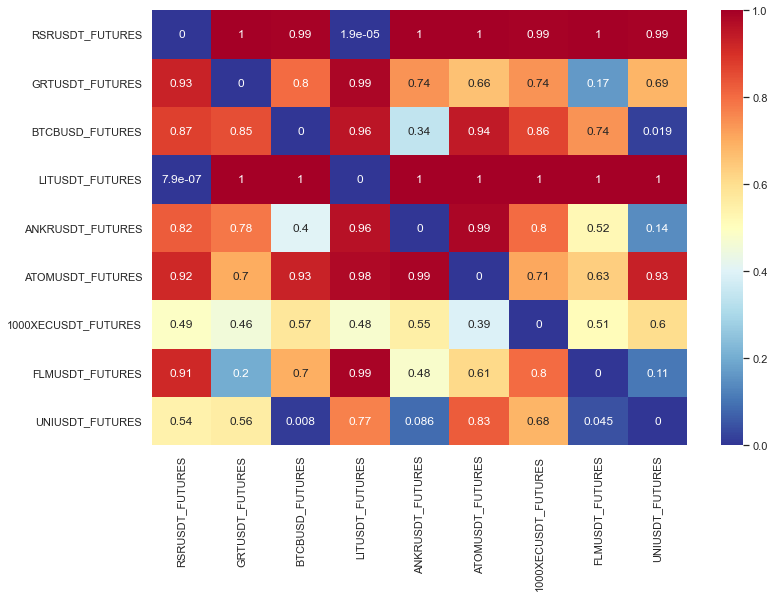

In [23]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
labels = df_closings.columns[11:20].values.flatten().tolist()
sns.heatmap(pvalue_matrix, cmap="RdYlBu_r", annot=True, robust=True, yticklabels=labels, xticklabels=labels)
plt.show()